In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

import copy

%matplotlib inline

In [2]:
train = MNIST('../DATASETS/MNIST_pytorch/', train=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
    ]),
#              download=True,
             )

test = MNIST('../DATASETS/MNIST_pytorch/', train=False, transform=transforms.ToTensor(),
#             download=True,
            )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=32)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [3]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1306)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [4]:
test_data = test.data
test_data = train.transform(test_data.numpy())

print('[Test]')
print(' - Numpy Shape:', test.data.numpy().shape)
print(' - Tensor Shape:', test.data.size())
print(' - Transformed Shape:', test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - Transformed Shape: torch.Size([28, 10000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1325)
 - std: tensor(0.3105)
 - var: tensor(0.0964)


In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 10)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(10, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = F.relu(h)        
        h = self.fc2(h)
        out = self.softmax(h)
        return out

model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
lambda_ = 1e-4

In [6]:
# for model_parm in model.parameters():
#     print(model_parm)

# print(model_parm.grad)

In [7]:
# model.train()
evaluate_x = Variable(test_loader.dataset.data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.targets)

losses = []
for epoch in range(5):
    data_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # creating a copy of model for every data
        model_list  = [copy.deepcopy(model) for _ in range(len(data))]
        
        for i, modeli in enumerate(model_list):
            optimizer = optim.Adam(modeli.parameters(), lr=0.001)
            
            for j in range(100):
                # Init
                optimizer.zero_grad()
                # Predict
                y_pred = modeli(data[i:i+1]) 
                # Calculate loss
#                 print(target.shape, i)
                loss = criterion(y_pred, target[i:i+1])

                losses.append(loss.data)
                # Backpropagation
                loss.backward()
                optimizer.step()
                
                if loss.data < 1e-5:
                    break
            
        ### combine the models
        model.zero_grad()
        for i, modeli in enumerate(model_list):
            for model_parm, modeli_parm in zip(model.parameters(), modeli.parameters()):
                if i == 0:
                    model_parm.grad = torch.zeros_like((model_parm - modeli_parm)/len(data)).data
                model_parm.grad += (model_parm - modeli_parm)/len(data)
            optimizer.step()
        
        
        # Display
        data_count += len(data)
        if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
            output = model(evaluate_x)
            pred = output.max(1)[1]
            d = pred.eq(evaluate_y)
            accuracy = float(d.sum())/float(d.size()[0])
            
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                epoch, 
                data_count, 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data,
                accuracy,),
                end='')
            
    print()

 Train Epoch: 0 [544/60000 (85%)]	Loss: 0.327817	Accuracy: 0.1081

KeyboardInterrupt: 

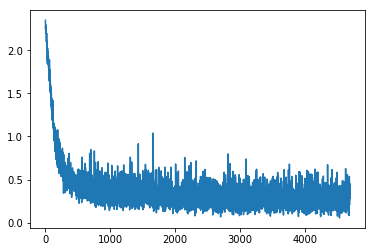

In [7]:
plt.plot(losses)

In [8]:
evaluate_x = test.data.type_as(torch.FloatTensor())
evaluate_y = test_loader.dataset.targets


output = model(evaluate_x)
pred = output.max(dim=1)[1]
d = pred.eq(evaluate_y)
accuracy = float(d.sum())/float(d.size()[0])

print('Accuracy:', accuracy)

Accuracy: 0.9053


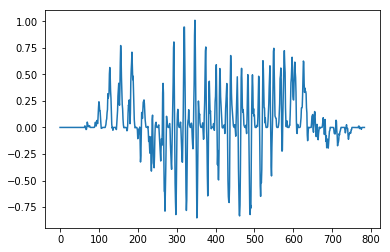

In [9]:
optimizer.zero_grad()
output = model(evaluate_x)
loss = criterion(output, evaluate_y)
loss.backward()
# model.fc1.weight.grad#.min()
plt.plot(model.fc1.weight.grad.data[0].numpy())

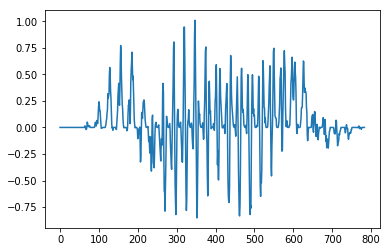

In [10]:
optimizer.zero_grad()
output = model(evaluate_x)
loss = criterion(output, evaluate_y)
        
loss_norm = 0
for parm in model.parameters():
    loss_norm += lambda_ * parm.norm(p=1)
loss += loss_norm
loss.backward()

plt.plot(model.fc1.weight.grad.data[0].numpy())